# Quantum state Tomography
#### Team #15
- Alexandr Talitsky
- Andrey Vlasov
- Anton Bozhedarov
- Nikolay Shvetsov
- Polina Pilyugina


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
%matplotlib inline

## Simulate experiment 
In this part we:
- generate state of qubit
- define experimental setup (i.e. how we should measure the qubit and how many copies of it we have)
- model experiment (obtain frequency probabilities outcomes)

In [2]:
# define how we will measure the system
def protocol(case = 'tetr', n = 1):
    """
    return matrix of measurement protocol, where
       row - measurement operator
       column - operator's coefficients
    case: 'tetr', 'xyz'
    n: number of qubits (int)
    """
    if case == 'tetr':
        sq3 = 1/np.sqrt(3)
        a0 = np.array([1,sq3,sq3,sq3])
        a1 = np.array([1,sq3,-sq3,-sq3])
        a2 = np.array([1,-sq3,sq3,-sq3])
        a3 = np.array([1,-sq3,-sq3,sq3])
        A = np.array([a0,a1,a2,a3])
        S = A
        for i in range(n-1):
            S = np.kron(S,A)
        S = S/S.shape[0]
    
    if case == 'xyz':
        x = np.array([1,1,0,0])
        y = np.array([1,0,1,0])
        z = np.array([1,0,0,1])
        A = [x,-x,y,-y,z,-z]
        S = A
        for i in range(n-1):
            S = np.kron(S, A)
        S = S/S.shape[0]
             
    return S

In [3]:
# model experiment's outcome
def measurements(E, rho, N = 1000, noise = 0):
    """
    returns frequency probabilies for measurements of state rho according to protocol E
    E - (nd.array)
    rho - state as expanded vector on Bloch sphere
    N - number of measurements (int)
    noise - level of noise while measurements (from 0 to 1)
    """
    if (noise > 1) or (noise < 0):
        print("incorrect level of noise")
        return False
    p = E@rho
    n = np.zeros(E.shape[0])
    pos_outcomes = np.arange(E.shape[0])
    
    outcomes = np.random.choice(pos_outcomes, size = N, p = p)
    
    if noise > 0:
        # level of noise
        noise_pos = np.random.choice([0,1], p = [1-noise, noise], size=N)
#         replace = np.random.choice(range(N), replace=False, size= int(N*noise) )
        outcomes[np.where(noise_pos == 1)] = np.random.choice(pos_outcomes, size = np.sum(noise_pos))
        
    beta = 0.5
    
    for i in range(E.shape[0]):
        ind = np.where(outcomes == pos_outcomes[i])
        n[i] = (len(ind[0])+beta)/(N+2*beta)
        
    return n

In [4]:
def gen_state(n = 1):
    """
    returns random state of n qubits
    """
    
    def rand_qubit():
        """
        returns random state of single qubit
        """
        fi = np.random.uniform(0, 2*np.pi)
        theta = np.arccos( np.random.uniform(-1., 1.) )
        x = np.cos(fi) * np.sin(theta)
        y = np.sin(fi) * np.sin(theta)
        z = np.cos(theta)
#         return np.array([1,0,0,1])
        return np.array([1,x,y,z])
        
    state = rand_qubit()   
    for i in range(n-1):
        state = np.kron(state, rand_qubit())
    
    return state

In [5]:
def pauli_dot(vector):
    """
    Scalar product of matrices Pauli and vector (to return ro matrix representation)
    """ 
    # Pauli matrixes
    X = np.matrix([[0, 1], [1, 0]], dtype = complex)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    s = np.array([I2,X,Y,Z])
    S = s
    
    # define number of qubits:
    k = int(np.log2(np.sqrt(len(vector))))
    
    for i in range(n-1):
        S =  np.kron(S,s)
        
    rho = S[0]*vector[0]/(2**k)
    for i in range(1,len(S)):
        rho = rho + 0.5 * S[i] * vector[i]
    
    return rho

In [15]:
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power

def hs_norm(rho_est, rho):
    return np.real((1/np.sqrt(2))*np.trace(sqrtm(matrix_power(rho_est - rho, 2))))

# def hs_norm(rho_est, rho):
#     return np.real(np.trace(matrix_power(rho_est - rho, 2)))

def t_norm(rho_est, rho):
    M = np.matrix(rho_est - rho)
    return np.real(0.5 * np.trace(sqrtm(M.H@M)))

def if_norm(rho_est, rho):
    sq = sqrtm(rho_est)
    mult = sqrtm(sq @ rho @ sq)
    return np.real((1-np.trace(matrix_power(mult, 2))))

Generate initial state as a vector $\rho_{vec} \in (\mathbb{R}^4)^{\otimes n}$, where $\rho_{vec}$[0] is always 1 (just convinient way of representation).

And then model experiment

In [16]:
n = 1 # number of qubits

E = protocol('tetr', n)

rho_vec = gen_state(n = n) # random state of system of n qubits

N = 1000 # number of measurements (i.e. numer of copies of a system)

b = measurements(E, rho_vec, N = N, noise=0.05) # here we obtain probabilities of measurement outcomes
# print(b)

## Recovery of the state
### Via inverse matrix

Tomography of the system (i.e. recovery of density matrix) is the solution of the following system:

$$
     S\rho_{vec} = b
$$

i.e. 
$$
    \rho_{vec} = (S*S)^{-1}S* b
$$

Then, we can return to density matrix representation

And then check whether our solution is physical, i.e.
- $\rho_{est} = \rho_{est}*$ (* means hermitian conjugation)
- $\rho_{est} \ge 0$
- $tr[\rho_{est}] \le 1$

In [17]:
S = np.matrix(E) # in this form it is easy to perfom hermitian conjugation

def find_rho(E, b):
    """
    return rho_est via pseudo inverse matrix
    """
    S = np.matrix(E)
    rho_vec_est = np.array((((S.H@S).I)@S.H)@b).reshape(-1)    
    return rho_vec_est

In [18]:
def check_physical(rho):
    '''
    Input: matrix rho
    Output: matrix rho, modified to be phisical
    '''            
    # Positive semi-definiteness
    eigenvalues, s = LA.eigh(rho)

    for i in range(eigenvalues.shape[0]):
        value = eigenvalues[i]
#         print(value)
        if eigenvalues[i] < 0:
            eigenvalues[i] = 0
    rho_modified = np.matmul(np.matmul(s, np.diag(eigenvalues)), LA.inv(s))

    
    # Trace adjustment
    tr = np.trace(rho_modified)
    if tr > 1:
        rho_modified = rho_modified/tr
    return rho_modified

In [19]:
snr = np.arange(0,0.85,0.05) # noise level
N = 1000
norm_t_d  = []
norm_hs_d = []
norm_if_d = []
zero_el = np.zeros((2,2))

for noise in snr:
    td = []
    hsd = []
    ifd = []
    
    for i in range(50):
        rho_vec = gen_state(n = 1) # random state of system of 1 qubit
        rho_true = pauli_dot(rho_vec)
        
        # here we obtain probabilities of measurement outcomes
        b = measurements(E, rho_vec, N = N, noise=noise) 
        
        rho = check_physical(pauli_dot(find_rho(S, b)))
        
        # append to arrays
#         td.append( t_norm(rho_true, rho)/t_norm(rho_true,zero_el)  )
#         hsd.append( hs_norm(rho_true, rho)/hs_norm(rho_true,zero_el) )
#         ifd.append( if_norm(rho_true, rho)/if_norm(rho_true,zero_el) )

        td.append( t_norm(rho_true, rho))
        hsd.append( hs_norm(rho_true, rho))
        ifd.append( if_norm(rho_true, rho))
        
    norm_t_d.append( sum(td)/len(td) )
    norm_hs_d.append( sum(hsd)/len(hsd) )
    norm_if_d.append( sum(ifd)/len(ifd) )

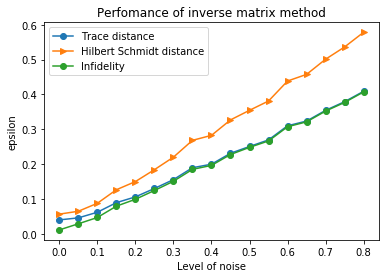

In [38]:
plt.plot(snr, norm_t_d, label = 'Trace distance', marker='o')
plt.plot(snr, norm_hs_d, label= 'Hilbert Schmidt distance', marker= '>')
plt.plot(snr, norm_if_d, label='Infidelity', marker='o')

plt.xlabel('Level of noise')
plt.ylabel('epsilon')
plt.title('Perfomance of inverse matrix method')
plt.legend()
plt.show()

### Gradient descent

We will maximize likelyhood function using gradient descent approach. Start with initial guess $\rho_0 = I/2$ (i.e. totally mixed state). Then, every iteration step we choose a direction of the fastest increasing of likelyhood function.

In [24]:
def operator_from_vec(vec):
    vec = np.array(vec).reshape(-1)
    X = np.matrix([[0, 1], [1, 0]], dtype = complex)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    s = np.array([I2,X,Y,Z])
    S = s

    # define number of qubits:
    k = int(np.log2(np.sqrt(len(vec))))
    
    for i in range(k-1):
        S =  np.kron(S,s)
        
#     rho = S[0]*vector[0]/(2**k)
    opert = np.zeros(S[0].shape)
    for i in range(S.shape[0]):
        opert = opert + S[i] * vec[i]
    
    return opert


def gradient(S, f, rho_vec, eps):
    """
    optimization of ML function via gradient descent method
    """
    rho = pauli_dot(rho_vec)
    
    def R(rho):
        S0 = operator_from_vec(S[0])
        p0 = np.trace(S0 @ rho)
        r = S0 * f[0]/p0
        for j in range(1,E.shape[0]):
            Sj = operator_from_vec(S[j])
            pj =  np.trace(Sj@rho)
            r = r + (Sj * f[j]/pj)
        return r
    
    def LLH(rho):
        return np.trace(R(rho) @ rho)
    
    def rho_next(eps, Rk):
        I = np.eye(rho.shape[0])
        numer = (I+eps/2*(Rk - I)) @ rho @ (I+eps/2*(Rk+I))
        denom = np.trace(numer)
        return numer/denom

    b = 1 # for setup of eps1, eps2
    LLH_c = LLH(rho)
    
    conv_t = []
    conv_hs = []
    conv_if = []
    zero_el = np.zeros((2,2))
    
    for k in range(1000):
        Rk = R(rho)
        eps_ar = np.array([0, np.random.rand(), np.random.rand()])*b
        
        LLH_1 = LLH(rho_next(eps_ar[1], Rk))
        LLH_2 = LLH(rho_next(eps_ar[2], Rk))        
        
        eps_c = np.argmin([LLH_c, LLH_1, LLH_2])
        
        rho_n = rho_next(eps_c, Rk)
        LLH_c = LLH(rho)
        
        # check if algorithm still are improoving current guess
        if (t_norm(Rk@rho,rho) + hs_norm(Rk@rho,rho) + if_norm(Rk@rho, rho)) < eps:
            break
        
        if k>1:
            conv_t.append(t_norm(rho, rho_n)/t_norm(rho, zero_el))
            conv_hs.append(hs_norm(rho, rho_n)/hs_norm(rho, zero_el))
            conv_if.append(if_norm(rho, rho_n)/if_norm(rho, zero_el))
        
        LLH_c = LLH(rho_n)
        rho = rho_n
        
    
    return rho, conv_t, conv_hs, conv_if

In [25]:
n = 1 
E = protocol('tetr', n)
S = np.matrix(E)

rho_vec = gen_state(n = n) # random state of system of n qubits

N = 1000
snr = np.arange(0,0.85,0.05) # noise level


hist_t = []
hist_hs = []
hist_if = []
rho_est_ar = []

for noise in snr:
    b = measurements(E, rho_vec, N = N, noise=noise)
    
    rho_est, h_t, h_hs, h_if = gradient(S, f = b, rho_vec=[1,0,0,0], eps = 1e-4)
    
    rho_est_ar.append(rho_est)
    hist_t.append(h_t)
    hist_hs.append(h_hs)
    hist_if.append(h_if)
    


In [26]:
ksi_t = []
ksi_hs = []
ksi_if = []
zero_el = np.zeros((2,2))
rho_true = pauli_dot(rho_vec)

for i in range(len(rho_est_ar)):
#     ksi_t.append( t_norm(rho_true, rho_est_ar[i])/t_norm(rho_true, zero_el))
#     ksi_hs.append( hs_norm(rho_true, rho_est_ar[i])/hs_norm(rho_true, zero_el))
#     ksi_if.append( if_norm(rho_true, rho_est_ar[i])/if_norm(rho_true, zero_el))
    
    ksi_t.append( t_norm(rho_true, rho_est_ar[i]))
    ksi_hs.append( hs_norm(rho_true, rho_est_ar[i]))
    ksi_if.append( if_norm(rho_true, rho_est_ar[i]))

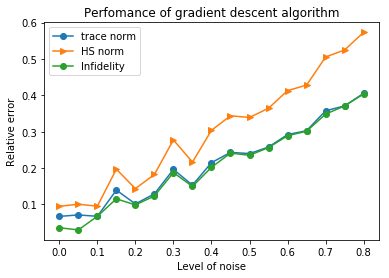

In [39]:
plt.plot(snr, np.real(ksi_t), label = 'trace norm', marker='o')
plt.plot(snr, np.real(ksi_hs), label = 'HS norm', marker= '>')
plt.plot(snr, np.real(ksi_if), label = 'Infidelity', marker='o')

plt.xlabel('Level of noise')
plt.ylabel('Relative error')
plt.title('Perfomance of gradient descent algorithm')
plt.legend()
plt.show()

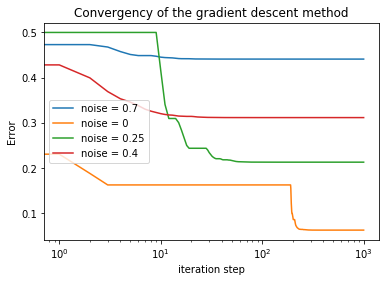

In [36]:
plt.semilogx(hist_if[14], label = 'noise = 0.7')
plt.semilogx(hist_if[0], label = 'noise = 0')
plt.semilogx(hist_if[5], label = 'noise = 0.25')
plt.semilogx(hist_if[8], label = 'noise = 0.4')
plt.legend()
plt.xlabel('iteration step')
plt.ylabel('Error')
plt.title('Convergency of the gradient descent method')
plt.show()

In [37]:
# n = 1
# def hml_iteration(S, rho_initial, f, eps = 1/N, beta = 0.5):
    
#     def R(rho):
#         S0 = operator_from_vec(S[0])
#         p0 = np.trace(S0 @ rho)
#         r = S0 * f[0]/p0
#         for j in range(1,E.shape[0]):
#             Sj = operator_from_vec(S[j])
#             pj =  np.trace(Sj@rho)
#             r = r + (Sj * f[j]/pj)
#         return r
    
#     def delta_k(rho):
#         dk = (eps/2)*( beta*(LA.pinv(rho) - 2*np.eye(2)) + N *(R(rho) - np.eye(2))  )
#         return dk
    
#     rho_k = rho_initial
#     for k in range(1000):
#         m = (np.eye(2) + delta_k(rho_k))
#         numer = m @ rho_k @ m
#         rho_k = numer/np.trace(numer)
        
#     return rho_k
    
# hml_iteration(S, np.eye(2), b) 
# # hml_iteration(S, pauli_dot(rho_vec), b)